In [1]:
import numpy as np
import glob
import librosa
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [2]:
TRAIN_DIR = "./train/audio/*/*.wav"
encoder = ce.BinaryEncoder()
waves = []
labels = []

In [3]:
wavfiles = glob.glob(TRAIN_DIR)

In [4]:
def get_wav(file_path : str, sr : int = 16000):
    wav ,_ = librosa.load(file_path, sr=sr)
    return wav

In [5]:
def get_label(file_path : str):
    parts = file_path.split("\\")
    return parts[-2]

In [6]:
def wav2spec(wav, sr : int = 16000, n_mels : int = 32):
    mlspec = librosa.feature.melspectrogram(wav, n_mels=n_mels, sr=sr)
    mlspec = librosa.power_to_db(mlspec)
    return mlspec

In [7]:
def coding_labels (labels):
    set_labels = list(set(labels))
    set_labels = sorted(set_labels)
    dict_labels = {value:key+1 for key, value in dict(enumerate(set_labels)).items()}
    ser_labels = pd.DataFrame(labels)
    ser_labels = encoder.fit_transform(ser_labels)
    del set_labels
    return (ser_labels, dict_labels)


In [8]:
for i in range(len(wavfiles)):
    wav = get_wav(wavfiles[i])
    label = get_label(wavfiles[i])
    waves.append(wav)
    labels.append(label)

In [9]:
waves = np.array(waves)
waves = tf.keras.preprocessing.sequence.pad_sequences(waves, maxlen=16000, dtype="float")

In [10]:
waves = list(waves)
for i in range(len(waves)):
    waves[i] = wav2spec(waves[i])
waves = np.array(waves)

In [11]:
waves = np.expand_dims(waves, -1)
waves.shape

(49081, 32, 32, 1)

In [12]:
wav_max = waves.max()
wav_min = waves.min()
waves_datas = (waves - wav_min)/(wav_max - wav_min)

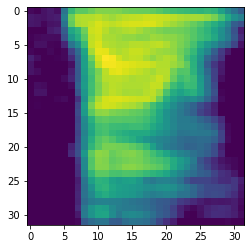

In [13]:
plt.clf()
plt.imshow(waves_datas[1234])

In [14]:
int_labels, dict_labels = coding_labels(labels)

E:\Users\Kosar 37638090\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
dict_labels

{'down': 1,
 'eight': 2,
 'five': 3,
 'four': 4,
 'go': 5,
 'left': 6,
 'nine': 7,
 'no': 8,
 'off': 9,
 'on': 10,
 'one': 11,
 'right': 12,
 'seven': 13,
 'six': 14,
 'stop': 15,
 'three': 16,
 'tree': 17,
 'two': 18,
 'up': 19,
 'yes': 20,
 'zero': 21}

In [16]:
int_labels = int_labels.values

In [17]:
wav_train, wav_test, label_train, label_test = train_test_split(waves_datas, int_labels, test_size=0.05, random_state=42, stratify=int_labels)

In [20]:
WE_INIT = tf.keras.initializers.RandomUniform(0., 0.2)

def res_block(layer, filters, kernel_size):
    layer_ = tf.keras.layers.Conv2D(filters, 1)(layer)
    layer_ = tf.keras.layers.BatchNormalization()(layer_)
    layer_ = tf.keras.layers.LeakyReLU(0.02)(layer_)
    layer_ = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(layer_)
    layer_ = tf.keras.layers.BatchNormalization()(layer_)
    layer_ = tf.keras.layers.LeakyReLU(0.02)(layer_)
    layer_ = tf.keras.layers.Conv2D(filters, 1)(layer_)
    layer_ = tf.keras.layers.BatchNormalization()(layer_)
    layer_ = tf.keras.layers.LeakyReLU(0.02)(layer_)
    
    layer = tf.keras.layers.Add()([layer_, layer])
    return layer


def max_pooling(layer, filters):
    layer = tf.keras.layers.Conv2D(filters, 5, strides=2, padding="same")(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.LeakyReLU(0.02)(layer)
    return layer

def model():
    input_layer = tf.keras.layers.Input(shape=(32, 32, 1))
    layer = tf.keras.layers.Conv2D(16, 5)(input_layer)
    layer = tf.keras.layers.LeakyReLU(0.02)(layer)
    layer = res_block(layer, 16, 5)
    layer = res_block(layer, 16, 5)
    layer = max_pooling(layer, 32)
    
    layer = res_block(layer, 32, 5)
    layer = res_block(layer, 32, 5)
    layer = max_pooling(layer, 64)
    
    layer = res_block(layer, 64, 5)
    layer = res_block(layer, 64, 5)
    layer = max_pooling(layer, 128)
    
    layer = tf.keras.layers.Flatten()(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
    layer = tf.keras.layers.Dense(64)(layer)
    layer = tf.keras.layers.LeakyReLU(0.02)(layer)
    output_layer = tf.keras.layers.Dense(6, activation=tf.keras.activations.sigmoid)(layer)
    
    return tf.keras.models.Model(input_layer, output_layer)

In [21]:
model = model()

In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 16)   416         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 28, 28, 16)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 16)   272         leaky_re_lu_4[0][0]              
_______________________________________________________________________________________

In [ ]:
model_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.2)
log_error = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=model_optimizer)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("./best_model.h5", monitor="val_loss", save_best_only=True)

In [ ]:
model.fit(wav_train, label_train, validation_data=(wav_test, label_test), batch_size=1024, epochs=1000, verbose=2, callbacks=[reduce_lr, model_checkpoint])

In [ ]:
pred=model.predict(wav_test)

In [ ]:
pred[1000]

In [ ]:
label_test[1000]

In [ ]:
test_voice = wav_test[1000]

In [ ]:
test_voice  = test_voice.squeeze(-1)
test_voice.shape

In [ ]:
test_voice = librosa.db_to_power(test_voice, ref=np.max)